importing the dataset to notebook environment

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sunilthite/llm-detect-ai-generated-text-dataset")

print("Path to dataset files:", path)

C:\Users\Admin\Documents\TextClassifierModel\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\sunilthite\llm-detect-ai-generated-text-dataset\versions\1


In [2]:
path

'C:\\Users\\Admin\\.cache\\kagglehub\\datasets\\sunilthite\\llm-detect-ai-generated-text-dataset\\versions\\1'

In [3]:
import pandas as pd
text_df = pd.read_csv(filepath_or_buffer=path+"/Training_Essay_Data.csv")

In [4]:
text_df[text_df['generated']==0].sample(3)

,text,generated
17402,"The quote, '' hard work pays,'' means a lot wh...",0
18282,"Some people be asking when some one ask them ""...",0
12412,State Senator I do wish for you to change the ...,0


data checks

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

def char_length_summary(df, column=None, top_n=5, bins=50, figsize=(10,4)):
    """
    Strictly character length analysis for `column` in `df`.
    If column is None, picks a likely text column.
    """
    if column is None:
        candidates = ['text', 'essay', 'content', 'article', 'body']
        found = [c for c in candidates if c in df.columns]
        if found:
            column = found[0]
        else:
            obj_cols = [c for c, dt in df.dtypes.items() if dt == object]
            if not obj_cols:
                raise ValueError("No string columns found; pass `column` explicitly.")
            column = obj_cols[0]
    if column not in df.columns:
        raise ValueError(f"Column `{column}` not found in DataFrame.")

    s = df[column].fillna("").astype(str)
    char_len = s.str.len()

    stats = {
        'count': int(char_len.count()),
        'mean': float(char_len.mean()),
        'median': float(char_len.median()),
        'std': float(char_len.std()),
        'min': int(char_len.min()),
        'max': int(char_len.max()),
    }
    print("Character-length stats:", stats)

    pct = [1,5,25,50,75,95,99]
    q = char_len.quantile([p/100 for p in pct])
    print("\nPercentiles (characters):")
    for p, v in zip(pct, q.values):
        print(f"{p}%: {int(v)}")

    # Plot: single histogram (boxplot removed)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.histplot(char_len, bins=bins, ax=ax, kde=False)
    ax.set_title("Character length histogram")
    ax.set_xlabel("Characters")
    plt.tight_layout()
    plt.show()

    # Examples
    print(f"\nTop {top_n} shortest examples (by characters):")
    short_idx = char_len.nsmallest(top_n).index
    for i in short_idx:
        print(f"[{i}] len={char_len.loc[i]} -> {s.loc[i]!s}")

    print(f"\nTop {top_n} longest examples (by characters):")
    long_idx = char_len.nlargest(top_n).index
    for i in long_idx:
        print(f"[{i}] len={char_len.loc[i]} -> {s.loc[i]!s}")

Character-length stats: {'count': 29145, 'mean': 2235.996740435752, 'median': 2158.0, 'std': 987.3462400175131, 'min': 1, 'max': 9157}

Percentiles (characters):
1%: 613
5%: 904
25%: 1505
50%: 2158
75%: 2750
95%: 4070
99%: 5237


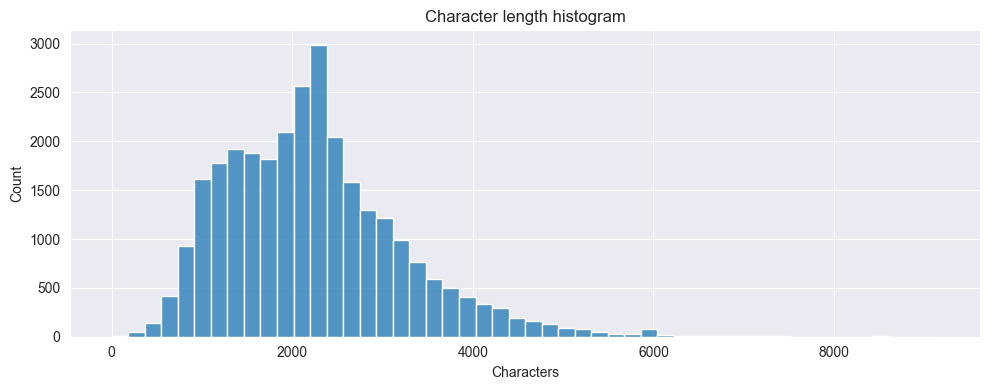


Top 5 shortest examples (by characters):
[2743] len=1 -> ]
[2744] len=24 -> ]
[Email]
[Phone Number]
[2735] len=26 -> ]

[Email]

[Phone Number]
[2753] len=32 -> ]
[Email Address]
[Phone Number]
[2825] len=32 -> ]
[Email Address]
[Phone Number]

Top 5 longest examples (by characters):
[3373] len=9157 -> Phones & driving

I strongly agree with cell phones being banned while driving. I can honestly say that I have almost run into someone's back on numerous occasions because I was focused on texting on my phone. I think driving while using cell phones should be banned because of the many car accidents they are causing, it is causing one's insurance to rise, and it is causing concern to people's health issues. The question is people more concerned more with their conveniences more than they are with their safety or safety of others. It is a habit that spreads like STDs. In the long run, it is deadly as well Cell phones are the omnipresent electronic device of this era, and multitasking is

In [6]:
char_length_summary(text_df, column='text')

## we will be training two models:
1. for whole essay classification
2. individual sentences classification

# <span style='color:green;'>whole essay classification model</span>

## <span style="color:#E5BAEE;">1. Data Cleaning</span>

1.1 text  normalization:
1. Lowercasing
2. unicode text normalization
3. removal of weird symbols

In [7]:
import re
import unicodedata
def clean_text(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text)
    # Remove URLs if any
    text = re.sub(r"http\S+|www\.\S+", "", text)

    # Remove HTML tags if any
    text = re.sub(r"<.*?>", "", text)

    # Remove extra whitespace but not inbetween words
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [8]:
text_df['clean_text'] = text_df['text'].apply(clean_text)

In [9]:
text_df

,text,generated,clean_text
0,Car-free cities have become a subject of incre...,1,car-free cities have become a subject of incre...
1,"Car Free Cities Car-free cities, a concept ga...",1,"car free cities car-free cities, a concept gai..."
2,A Sustainable Urban Future Car-free cities ...,1,a sustainable urban future car-free cities are...
3,Pioneering Sustainable Urban Living In an e...,1,pioneering sustainable urban living in an era ...
4,The Path to Sustainable Urban Living In an ...,1,the path to sustainable urban living in an age...
...,...,...,...
29140,There has been a fuss about the Elector Colleg...,0,there has been a fuss about the elector colleg...
29141,Limiting car usage has many advantages. Such a...,0,limiting car usage has many advantages. such a...
29142,There's a new trend that has been developing f...,0,there's a new trend that has been developing f...
29143,As we all know cars are a big part of our soci...,0,as we all know cars are a big part of our soci...


### ℹ️ important: punctuation is retained as it can be a proxy for writing style

## <span style="color:#E5BAEE;">2. Feature Engineering</span>
To classify AI vs human essays, the model must learn:

wording patterns

sentence structure patterns

transitions

vocabulary richness

repetitive phrasing

paragraph coherence

2.1 TF-IDF N-grams

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    lowercase=False,
    ngram_range=(1,3),
    min_df=5,
    max_df=0.9,
    max_features=50_000
)
X = vectorizer.fit_transform(text_df['clean_text'])
y = text_df['generated']

## 2.2 Stylometric Features (Boosts Accuracy)

AI text has predictable stylometric characteristics.

Addition of features like:

avg sentence length

paragraph count

punctuation count

lexical diversity

ratio of stopwords

uppercase/lowercase usage

average word length

In [11]:
# python
import spacy
from spacy.cli import download
import sys

try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    # Attempt to download the model into the current environment and load again
    print("Model 'en_core_web_sm' not found — downloading now...")
    download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

# now safe to use nlp(...)

In [12]:
import numpy as np
import spacy

nlp = spacy.load('en_core_web_sm')

def extract_style_features(text):
    doc = nlp(text)

    sentences = list(doc.sents)
    words = [token.text for token in doc if token.is_alpha]

    avg_sentence_len = np.mean([len(sent.text.split()) for sent in sentences])
    avg_word_len = np.mean([len(w) for w in words])
    lexical_diversity = len(set(words)) / (len(words) + 1e-6)

    return [
        avg_sentence_len,
        avg_word_len,
        lexical_diversity,
        len(sentences)
    ]

In [13]:
style_features = np.array(text_df['clean_text'].apply(extract_style_features).tolist())

C:\Users\Admin\Documents\TextClassifierModel\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Admin\Documents\TextClassifierModel\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 